In [1]:
suppressWarnings({
    library(data.table)
    library(geosphere)
    source("preprocess_utils.R")
    library(parallel)
    library(ggplot2)
    library(feather)
    library(dplyr)
    library(tidyverse)
})

landing_ac_data <- ac_data <- read_feather("full_ac_data.feather")
print(nrow(ac_data))
setDT(ac_data)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  m

[1] 5019380


In [2]:
ground_speed_limit <- 3000 # knots
max_climb_rate <- 200 # ft/s
min_reqd_alt <- 10000 # ft
max_ground_speed_est_ratio <- 20
setorder(landing_ac_data, id, ts)

In [3]:
ac_data$time_diff_condition <- (is.na(ac_data$next_ts) | ((ac_data$next_ts - ac_data$ts) > 1800))
ac_data$alt_diff_condition <- ((ac_data$altitude - ac_data$last_altitude) < 0) |
                                ((ac_data$next_altitude - ac_data$altitude) < 0)


ac_data$landing_condition <- data.table::between(x = ac_data$lon, lower = -75, upper = -72.5) &
                      data.table::between(x = ac_data$lat, lower = 40, upper = 42) &
                        ac_data$altitude <= 1500 & ac_data$alt_diff_condition &
                        ac_data$time_diff_condition
ac_data[, "landing" := cumsum(landing_condition), by=id]
ac_data[, "land_max" := max(landing), by = id]
landing_ac_data <- ac_data[ac_data$land_max != 0, ]

In [4]:
length(unique(landing_ac_data$id))

[1] 62

In [5]:
# Keeping first row of lon, lat for each aircraft
setorder(landing_ac_data, id, ts)
landing_ac_data[, c("last_lon", "last_lat") := list(c(NA, lon[-.N]), c(NA, lat[-.N])), by = "id"]
landing_ac_data <- landing_ac_data[landing_ac_data$lon != landing_ac_data$last_lon | landing_ac_data$lat != landing_ac_data$last_lat, ]
print(nrow(ac_data))
landing_ac_data[, c("last_ts", "last_lon", "last_lat") := list(c(NA, ts[-.N]), c(NA, lon[-.N]), c(NA, lat[-.N])), by = "id"]

[1] 5019380


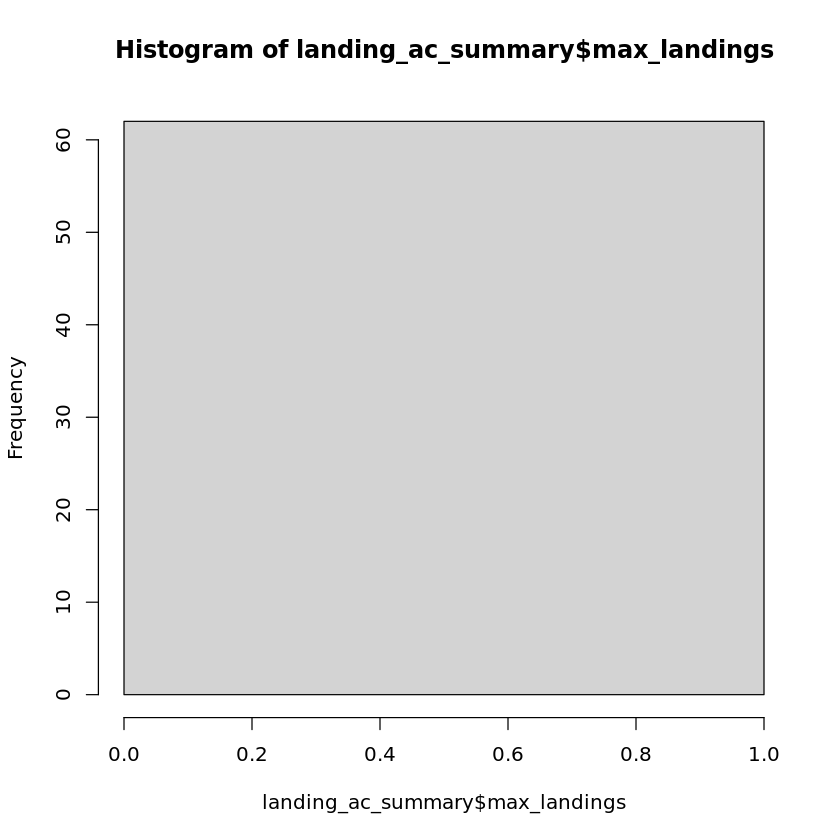

In [6]:
landing_ac_summary <- landing_ac_data %>% group_by(id) %>% summarize(max_landings = max(land_max, na.rm = T))
hist(landing_ac_summary$max_landings)

In [7]:
nrow(landing_ac_data)
landing_ac_data <- landing_ac_data[, .SD[-c(1)], by = id]
nrow(landing_ac_data)
landing_ac_data[, "landing_ac" := data.table::between(x = lon[.N], lower = -74.2, upper = -73.3) &
                                          data.table::between(x = lat[.N], lower = 40.3, upper = 41) &
                altitude[.N] <= 1500,
                                            by = id]
landing_ac_data <- landing_ac_data[landing_ac_data$landing_ac, ]
nrow(landing_ac_data)

[1] 15692

[1] 15630

[1] 9911

In [8]:
landing_ac_data[, "alt" := altitude[.N], by = id]
range(landing_ac_data$alt)

[1]    0 1400

In [9]:
landing_ac_data[, c("max_alt") := list(max(altitude, na.rm = T)), by = id]
landing_ac_data <- landing_ac_data[landing_ac_data$max_alt >= min_reqd_alt, ]
nrow(landing_ac_data)

[1] 8535

In [10]:
landing_ac_data$ground_speed_est <- 9/4.63 * apply(landing_ac_data[, c("lon", "lat", "last_lon", "last_lat")], 1, ground_dist)/as.numeric(landing_ac_data$ts - landing_ac_data$last_ts)
landing_ac_data[, "max_ground_speed_est" := max(ground_speed_est), by = id]


In [11]:
mean(landing_ac_data$max_ground_speed_est <= ground_speed_limit)

[1] 1

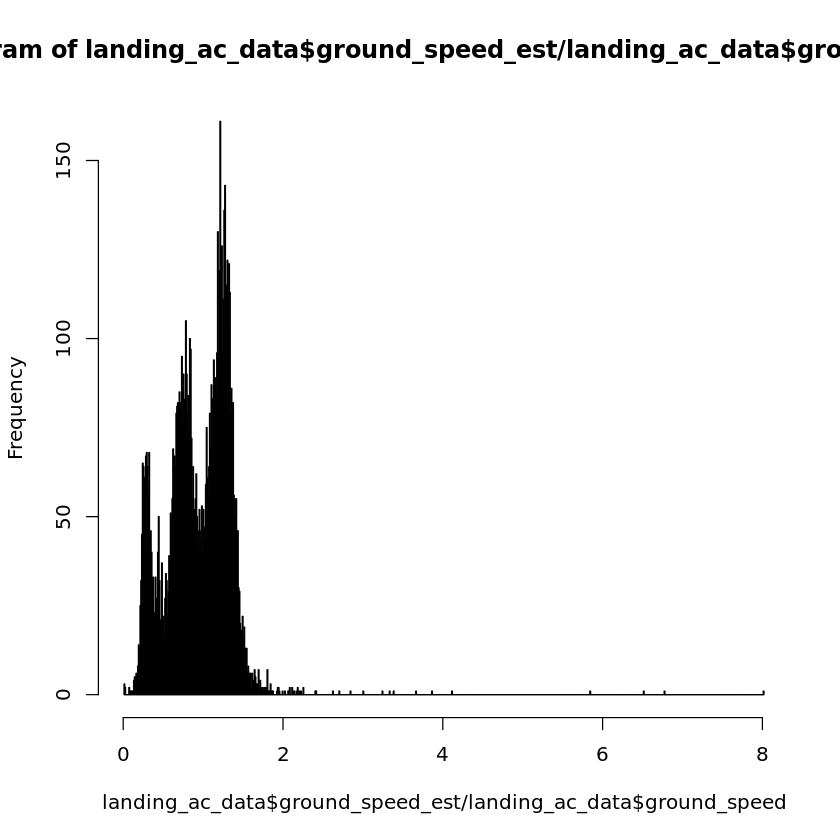

In [12]:
hist(landing_ac_data$ground_speed_est/landing_ac_data$ground_speed, breaks = 1000)

[1] 0.9996485

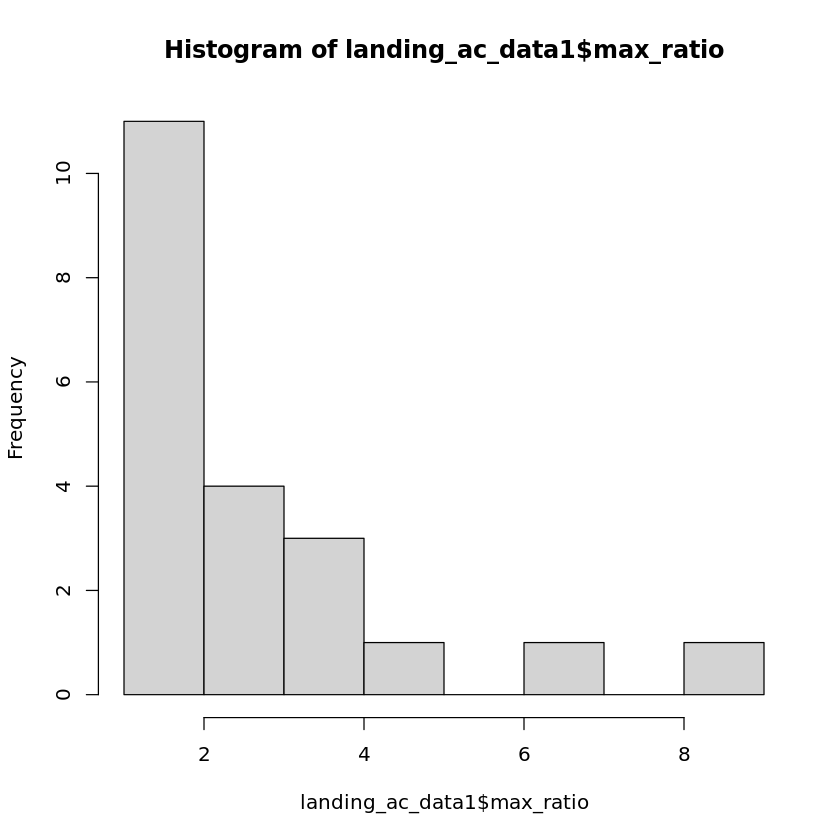

In [13]:
mean(landing_ac_data$ground_speed_est/landing_ac_data$ground_speed <= 20)
landing_ac_data[, "max_ratio" := max(ground_speed_est/ground_speed), by = id]
landing_ac_data1 <- unique(landing_ac_data[, c("id", "max_ratio")])
hist(landing_ac_data1$max_ratio)

In [14]:
nrow(landing_ac_data)
mean(landing_ac_data1$max_ratio <= max_ground_speed_est_ratio)
reqd_ids <- landing_ac_data1$id[landing_ac_data1$max_ratio <= max_ground_speed_est_ratio]
landing_ac_data <- landing_ac_data[sapply(landing_ac_data$id, function(id1) id1 %in% reqd_ids), ]
nrow(landing_ac_data)

[1] 8535

[1] 0.875

[1] 7568

In [15]:
landing_ac_data <- landing_ac_data[landing_ac_data$max_ground_speed_est <= max_ground_speed_est, ]
print(nrow(landing_ac_data))

[1] 7568


In [16]:
landing_ac_data[, "last_alt" := c(NA, altitude[-.N]), by = id]
ht_df <- landing_ac_data[landing_ac_data$altitude != landing_ac_data$last_alt, ]
setorder(ht_df, id, ts)

In [17]:
nrow(ht_df)

[1] 3607

In [18]:
ht_df[, "last_ts" := c(NA, ts[-.N]), by = id]
ht_df$climb_rate <- (ht_df$altitude - ht_df$last_alt)/as.numeric(ht_df$ts - ht_df$last_ts) # ft/s

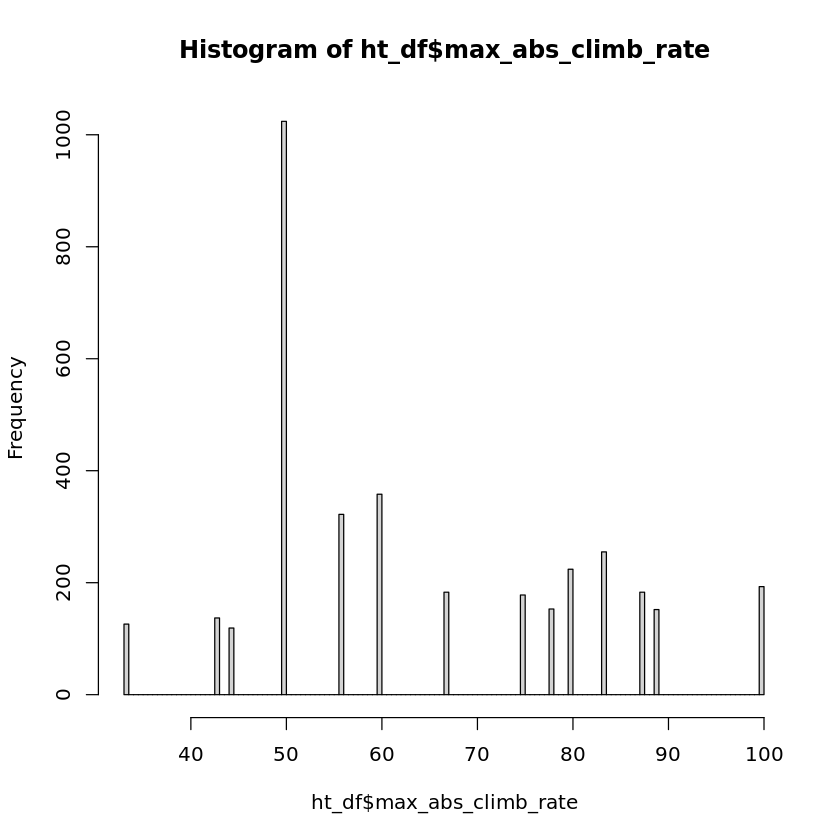

In [19]:
ht_df[, "max_abs_climb_rate" := max(abs(climb_rate), na.rm = T), by = id]
hist(ht_df$max_abs_climb_rate, breaks = 100)

In [20]:
mean(ht_df$max_abs_climb_rate <= max_climb_rate)
clean_landing_id <- unique(ht_df$id[ht_df$max_abs_climb_rate <= max_climb_rate])
length(clean_landing_id)

[1] 1

[1] 21

In [21]:
landing_ac_data <- landing_ac_data[sapply(landing_ac_data$id, function(id1) id1 %in% clean_landing_id), ]

In [22]:
nrow(landing_ac_data)

[1] 7568

landing_ac_data <- filter_m_min_r_rows(landing_ac_data)

In [23]:
length(unique(landing_ac_data$id))

[1] 21

In [24]:
world <- map_data("world")
a_region <- filter(world, long > -78 & long < -68 & lat > 35 & lat < 45)

In [25]:
dir.create("clean_landed_id", showWarnings = F)
setwd("clean_landed_id/")
uniq_id <- unique(landing_ac_data$aircraft)
plot_ids <- plot_aircraft_ids(jfk_data1 = landing_ac_data, a_region = a_region,
                              min_lon = min(landing_ac_data$lon), max_lon = max(landing_ac_data$lon),
                              min_lat = min(landing_ac_data$lat), max_lat = max(landing_ac_data$lat))
suppressWarnings({
    plot_ids(uniq_id = uniq_id)
})
# landing_ac_data <- get_quadrant(landing_ac_data)

In [27]:
write_feather(landing_ac_data, "landing_subset_refined.feather")